In [1]:
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import style
style.use('ggplot')
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from enum import Enum
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score, classification_report, ConfusionMatrixDisplay, confusion_matrix

class VectorizerType(Enum):
    COUNT = 1
    TFID = 2
    
class DatasetType(Enum):
    TWITTER = 1
    WIKI = 2
    FOX = 3
    REDDIT = 4
    STORMFRONT = 5
    HATECHECK = 6
    CONV_AI = 7
    FB_TY = 8
    TWI_FB = 9
    YT_REDDIT = 10

# Helper Methods

#### Load Dataset

In [2]:
def LoadDataset(FileName):
    df = pd.read_csv(FileName)
    fig = plt.figure(figsize=(3,3))
    sns.heatmap(df.isnull(),yticklabels=False)
    df.info()
    return df

#### Data Cleaning and Preprocessing

In [3]:
def basic_data_cleaning(df):
    # drop rows with null values
    df = df.dropna()

    # drop unnecessary columns
    df = df.drop(columns=['id','file_platform','file_language', 'file_name', 'labels'])

    #drop duplicates
    df = df.drop_duplicates('text')

    #change data type of binary labels to int
    df['binary_labels'] = df['binary_labels'].astype('int')

    #rename the column name to labels
    df = df.rename(columns={"binary_labels": "labels"})

    #see the changes made
    df.info()
    
    return df

In [4]:
def data_processing(df, datasetType):
    df = df.lower() #convert everything to lowercase
    if datasetType == DatasetType.TWITTER:
        df = re.sub(r"http\S+", "", df) #removing links
        df = re.sub(r"\@\S+", "", df) #removing usernames @...
        df = re.sub(r"[0-9]+","",df) #removing numbers
        df = re.sub(r"\b([a-z]+[0-9]+|[0-9]+[a-z]+)[a-z0-9]*\b","",df) #removing alphanumeric words
        df = re.sub(r"[^\w\s]","",df) #remove punctuations
        df = re.sub(r"amp","",df) #remove irrelevant words detected in wordcloud
        df = re.sub(r"rt","",df) 
        df = re.sub(r"mkr","",df) 
    elif datasetType == DatasetType.WIKI:
        df = re.sub(r"http\S+", "", df) #removing links
        df = re.sub(r"[0-9]+","",df) #removing numbers
        df = re.sub(r"[^\w\s]","",df) #remove punctuations
    
    # tokenization
    df_tokens = word_tokenize(df)
    
    #removing stopwords
    filtered_df = [w for w in df_tokens if not w in stop_words]
    
    #lemmatization
    lemmatizer = WordNetLemmatizer()
    lemmatized_df = [lemmatizer.lemmatize(w) for w in filtered_df ]
        
    return " ".join(lemmatized_df)

#### Visualization

In [5]:
def visualize_label_distribution(df):
    fig = plt.figure(figsize=(3,3))
    sns.countplot(x='labels', data = df)

    fig = plt.figure(figsize=(3,3))
    colors = ("red", "gold")
    wp = {'linewidth':2, 'edgecolor':"black"}
    tags = df['labels'].value_counts()
    explode = (0.1, 0.1)
    tags.plot(kind='pie',autopct = '%1.1f%%', shadow=True, colors = colors, startangle =90, 
         wedgeprops = wp, explode = explode, label='')
    plt.title('Label Distribution in Twitter Dataset')

In [6]:
def visualize_word_cloud(Data, Title):
    text = ' '.join([word for word in Data])
    plt.figure(figsize=(10,10), facecolor='w')
    wordcloud = WordCloud(max_words=500, width=1600, height=800).generate(text)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(Title, fontsize = 19)
    plt.show()

#### Vectorize

In [7]:
def Vectorize(mode,minRange,maxRange):
    if mode == VectorizerType.COUNT:
        return CountVectorizer(analyzer='word', ngram_range=(minRange, maxRange))
    if mode == VectorizerType.TFID:
        return TfidfVectorizer(analyzer='word', ngram_range=(minRange, maxRange))

#### Train Test Validation Split

In [19]:
def train_validate_test_split(vectorizer, XData, YData):
    X = vectorizer.fit_transform(XData)
    Y = YData
    x, x_test, y, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
    x_train, x_validate, y_train, y_validate = train_test_split(x, y, test_size=0.1, random_state=42)
    return x_train, x_validate, x_test, y_train, y_validate, y_test

#### Get Best Model

In [9]:
def get_best_model(x_train, y_train, x_validate, y_validate, params):
    bestModel = None
    bestScore = -0.0000000001
    
    # hyperparameter tuning
    for i in params:
        model = MultinomialNB(alpha=i)
        model.fit(x_train, y_train)
        y_predict = model.predict(x_validate)
        score = f1_score(y_validate, y_predict, average='macro')
        if score > bestScore:
            bestScore = score
            bestModel = model
            
    return bestModel

#### Apply Naive Bayes

In [10]:
def GenericNaiveBayes(vect, df_X, df_Y):
    x_train, x_validate, x_test, y_train, y_validate, y_test = train_validate_test_split(vect, df_X, df_Y)
    params = [0.001,0.01,0.1,0.2,0.4,0.6,0.8, 1,2,3]
    model = get_best_model(x_train, y_train, x_validate, y_validate, params)
    y_predict = model.predict(x_test)
    f1 = EvaluatePerformance(y_test, y_predict)
    return model, f1, y_test, y_predict

#### Evaluation

In [11]:
def EvaluatePerformance(y_test, y_predict):
    f1 = f1_score(y_test, y_predict, average='macro')
    accuracy = accuracy_score(y_test, y_predict)
    precision = precision_score(y_test, y_predict, average='macro')
    recall = recall_score(y_test, y_predict, average='macro')

    print("F1 Score: ", f1)
    print("Accuracy: ", accuracy)
    print("Precision: ", precision)
    print("Recall: ", recall)
    return f1

In [12]:
def Confusion_Matrix(y_test, y_predict, model):
    print(classification_report(y_test, y_predict))
    style.use('classic')
    cm = confusion_matrix(y_test, y_predict, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()

# Twitter Dataset

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 337747 entries, 0 to 337746
Data columns (total 7 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id             337747 non-null  int64  
 1   file_platform  337747 non-null  object 
 2   file_language  337747 non-null  object 
 3   file_name      337747 non-null  object 
 4   text           337747 non-null  object 
 5   labels         132815 non-null  object 
 6   binary_labels  132815 non-null  float64
dtypes: float64(1), int64(1), object(5)
memory usage: 18.0+ MB


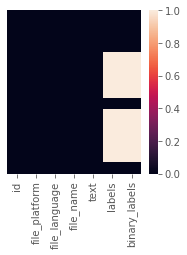

In [13]:
tweet_df = LoadDataset("Twitter.csv")

### Data Cleaning and Preprocessing

#### Handled
- Removal of Unwanted Observations
    - Remove rows with null values in labels
    - Remove unnecessary columns
    - Remove duplicates
- Fixing Structure
    - Rename column names where needed
    - Fix Data Types
- Fixing Tweet Message Structure with Text Processing
    - Remove URLs
    - Remove @ references
    - Remove special characters
    - Remove numbers
    - Remove alphanumeric words
    - emojis
- Tokenize with English Stopwords
- Apply lemmatizer
    
#### Not Handled:
- Other Language text incorrectly labelled as English
- words with incorrect whitespaces
- Meaningless words
- usernames

In [15]:
tweet_df = basic_data_cleaning(tweet_df)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 126010 entries, 0 to 337746
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    126010 non-null  object
 1   labels  126010 non-null  int32 
dtypes: int32(1), object(1)
memory usage: 2.4+ MB


In [16]:
print("==================Before Processing===============\n")
print(tweet_df['text'].iloc[11121],"\n")
print(tweet_df['text'].iloc[11433],"\n")
print(tweet_df['text'].iloc[11455],"\n")
print(tweet_df['text'].iloc[0],"\n")
print(tweet_df['text'].iloc[1],"\n")
print(tweet_df['text'].iloc[2],"\n")
print(tweet_df['text'].iloc[3],"\n")
print(tweet_df['text'].iloc[4],"\n")

tweet_df.text = tweet_df['text'].apply(data_processing, datasetType = DatasetType.TWITTER)

print("\n\n==================After Processing===============\n")
print(tweet_df['text'].iloc[11121],"\n")
print(tweet_df['text'].iloc[11433],"\n")
print(tweet_df['text'].iloc[11455],"\n")
print(tweet_df['text'].iloc[0],"\n")
print(tweet_df['text'].iloc[1],"\n")
print(tweet_df['text'].iloc[2],"\n")
print(tweet_df['text'].iloc[3],"\n")
print(tweet_df['text'].iloc[4],"\n")

==================Before Processing===============

" got ya bitch tip toeing on my hardwood floors " &#128514; http://t.co/cOU2WQ5L4q 

"@hxhassan: Jihadi patron Hajjaj al-Ajmi is arrested at Kuwait airport https://t.co/ZmloKfWDQl" 

"@leikant: This is so fucking hot!! #scally #sneakersex #sockfetish #sniff #trainersex http://t.co/TubivxbxcO" love me some kinky scallies 

If America had another 8 years of Obama's ideology via Hillary we'd be well on our way to being a shithole country. 

Most Canadians have never met seen or associated with a person who are currently labelled as \retarded\ . I plan t\u2026 @URL 

Hahaha grow up faggot @URL 

@user queue is fucking retarded it makes everyone feel like they don't even have a chance make it fcfs again for fucksake 

@user Que ce ne soit pas des Burundais refugies Alerte car leur corps sont visibles a loeil nu 



==================After Processing===============

got ya bitch tip toeing hardwood floor 

jihadi patron hajjaj alajmi arrest

### Visualization

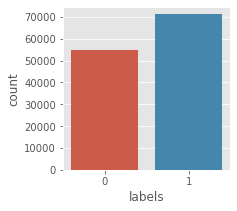

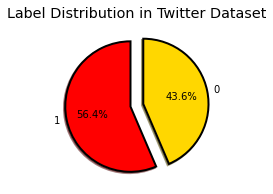

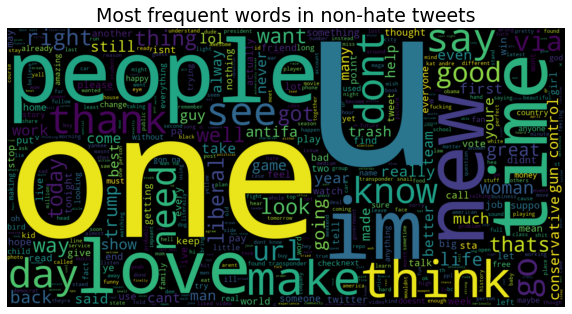

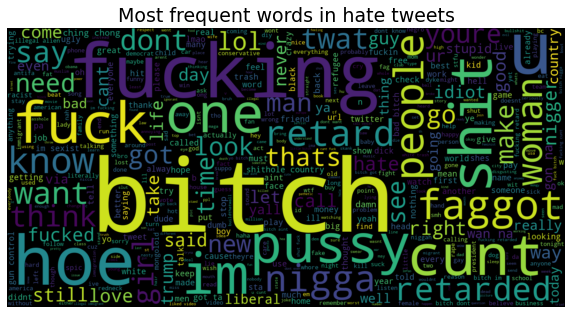

In [17]:
visualize_label_distribution(tweet_df)

#visualize most frequent words in non-hate tweets
non_hate_tweets = tweet_df[tweet_df.labels == 0]
visualize_word_cloud(non_hate_tweets['text'], "Most frequent words in non-hate tweets")

#visualize most frequent words in non-hate tweets
hate_tweets = tweet_df[tweet_df.labels == 1]
visualize_word_cloud(hate_tweets['text'], "Most frequent words in hate tweets")

### Model Building

============= TESTING WITH VECTORIZER  CountVectorizer()  =============
F1 Score:  0.819951844054325
Accuracy:  0.8227521625267836
Precision:  0.8204321518108924
Recall:  0.8195249667480557
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.8213500276448145
Accuracy:  0.8244186969288152
Precision:  0.8224966758444241
Recall:  0.8204483614234004
============= TESTING WITH VECTORIZER  CountVectorizer(ngram_range=(2, 2))  =============
F1 Score:  0.7529219319179952
Accuracy:  0.75791603840965
Precision:  0.7550377944122504
Recall:  0.7516460447115674
============= TESTING WITH VECTORIZER  TfidfVectorizer()  =============
F1 Score:  0.7943500514022669
Accuracy:  0.7996190778509642
Precision:  0.7997593042348373
Recall:  0.7917869869585938
============= TESTING WITH VECTORIZER  TfidfVectorizer(ngram_range=(1, 2))  =============
F1 Score:  0.8055122149788672
Accuracy:  0.8092611697484327
Precision:  0.8075496786851686
Recall:  0.80413293878

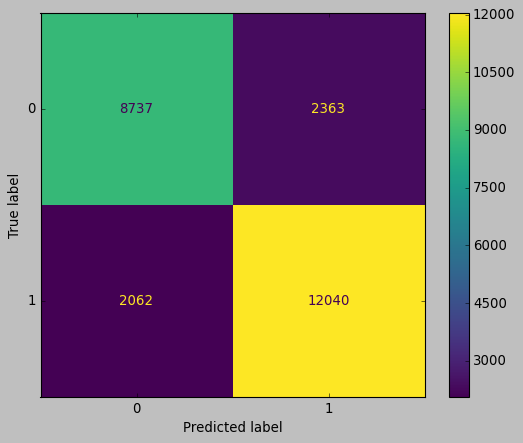

In [20]:
vectorizer = []
vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 1))
vectorizer.append(Vectorize(VectorizerType.COUNT, 1, 2))
vectorizer.append(Vectorize(VectorizerType.COUNT, 2, 2))
vectorizer.append(Vectorize(VectorizerType.TFID, 1, 1))
vectorizer.append(Vectorize(VectorizerType.TFID, 1, 2))
vectorizer.append(Vectorize(VectorizerType.TFID, 2, 2))

Twitter_model = None
Twitter_vect = None
Twitter_y_test = None
Twitter_y_predict = None
score = -0.00000000001

for i in vectorizer:
    print("============= TESTING WITH VECTORIZER ", i, " =============")
    model, f1, y_test, y_predict = GenericNaiveBayes(i, tweet_df['text'], tweet_df['labels'])
    if f1 > score:
        score = f1
        Twitter_model = model
        Twitter_vect = i
        Twitter_y_test = y_test
        Twitter_y_predict = y_predict
print("\n\nBEST MODEL IS ", Twitter_model, " , ", Twitter_vect)
Confusion_Matrix(Twitter_y_test, Twitter_y_predict, Twitter_model)